In [1]:
import pandas as pd
import numpy as np
# from src.utils_analysis import (
#     calculate_portfolio_values,
#     plot_daily_returns_histogram,
#     calculate_cumulative_return,
#     calculate_sharpe_ratio,
#     calculate_daily_mean_std,
#     plot_portfolio_value_and_daily_return,
#     plot_individual_ticker_values,
#     calculate_log_returns
# )
from src.utils_analysis import plot_all_result, calculate_log_returns
from src.optimization.minimization_algo import maximize_sharpe_ratio
from src.optimization.monte_carlo_optimization import (
    monte_carlo_simulation,
    simulated_annealing,
    plot_both
)

### Load data

In [2]:

# Load selected tickers from file
with open("data/selected_cluster_stocks.txt", "r") as f:
    tickers = [line.strip() for line in f]

# Define the file path template
test_file_path_template = "data/processed_data/test/{}_processed.csv"

# Load preprocessed data into a dictionary
test_data_dict = {}
for ticker in tickers:
    # Load each ticker's data and assume it has 'Normed Return' and other necessary columns
    test_data_dict[ticker] = pd.read_csv(test_file_path_template.format(ticker), index_col='date', parse_dates=True)

# Define the file path template
train_file_path_template = "data/processed_data/train/{}_processed.csv"

# Load preprocessed data into a dictionary
train_data_dict = {}
for ticker in tickers:
    # Load each ticker's data and assume it has 'Adj Close' or 'Normed Return' for log return calculation
    train_data_dict[ticker] = pd.read_csv(train_file_path_template.format(ticker), index_col='date', parse_dates=True)

# Set the starting amount for the portfolio
start_amount = 10000
num_tickers = len(tickers)
# Calculate log returns for all tickers
log_returns = calculate_log_returns(train_data_dict)


### Equal allocation results:

In [13]:

allocations_EQ = {ticker: 1 / num_tickers for ticker in tickers}
import json
with open('data/weights/EQ.json', 'w') as f:
    json.dump(allocations_EQ, f)


In [ ]:

plot_all_result(allocations,test_data_dict,start_amount)


### Optimization Results:

In [4]:
optimization_results = maximize_sharpe_ratio(log_returns)
optimal_weights = optimization_results['Optimal Weights']

# Convert optimal weights to dictionary format for use in calculate_portfolio_values
allocations = {ticker: weight for ticker, weight in zip(log_returns.columns, optimal_weights)}

Cumulative Portfolio Return: -4.94%
Daily Sharpe Ratio: -0.0109
Annualized Sharpe Ratio: -0.1730
Mean of Total Daily Return: -0.0109%
Standard Deviation of Total Daily Return: 1.3676%


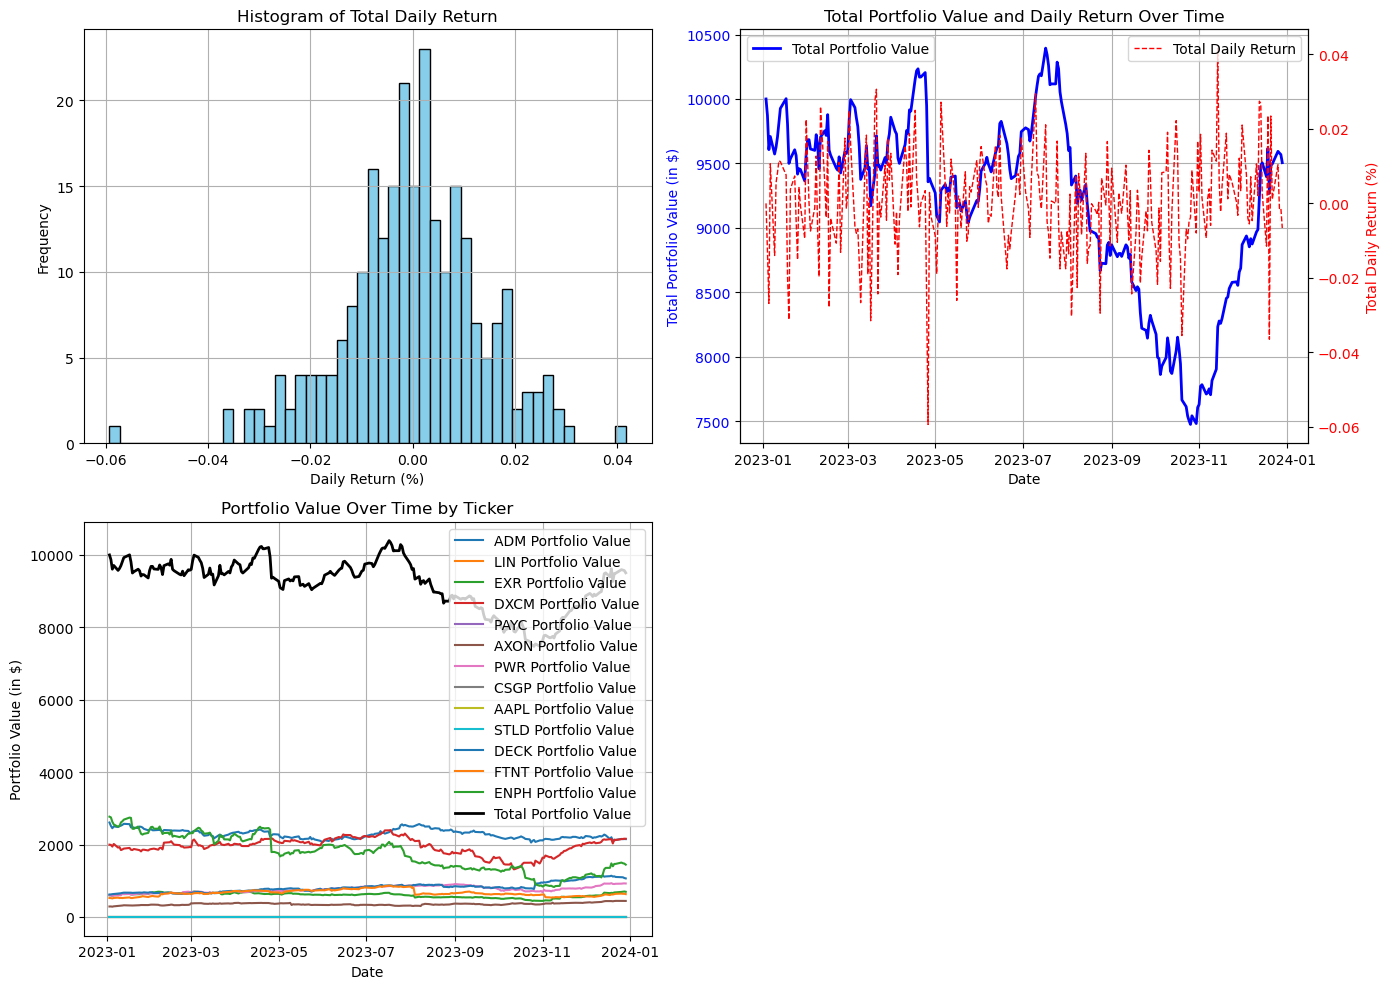

In [5]:
plot_all_result(allocations,test_data_dict)

### Monte Carlo Results:

In [6]:
# Run Random Monte Carlo simulation
results_df_mc, weights_df_mc = monte_carlo_simulation(log_returns, num_simulations=100000)

# Identify the best result from Monte Carlo simulation
best_sharpe_idx_mc = results_df_mc['Sharpe Ratio'].idxmax()
best_weights_mc = weights_df_mc.iloc[best_sharpe_idx_mc]
best_return_mc = results_df_mc.iloc[best_sharpe_idx_mc]['Return']
best_volatility_mc = results_df_mc.iloc[best_sharpe_idx_mc]['Volatility']
best_sharpe_ratio_mc = results_df_mc.iloc[best_sharpe_idx_mc]['Sharpe Ratio']

# Print best result from Monte Carlo
print("Best Portfolio from Monte Carlo Simulation:")
print(f"Weights:\n{best_weights_mc}")
print(f"Expected Return: {best_return_mc:.4f}")
print(f"Expected Volatility: {best_volatility_mc:.4f}")
print(f"Sharpe Ratio: {best_sharpe_ratio_mc:.4f}")
print("\n")


Best Portfolio from Monte Carlo Simulation:
Weights:
ADM     0.091059
LIN     0.025964
EXR     0.070845
DXCM    0.150665
PAYC    0.004706
AXON    0.128662
PWR     0.033038
CSGP    0.054709
AAPL    0.049502
STLD    0.041435
DECK    0.093122
FTNT    0.001303
ENPH    0.254990
Name: 12761, dtype: float64
Expected Return: 0.4473
Expected Volatility: 0.3475
Sharpe Ratio: 1.2872




In [14]:
# Define allocations
allocations_MC = {ticker: weight for ticker, weight in best_weights_mc.items()}
import json
with open('data/weights/MC.json', 'w') as f:
    json.dump(allocations_MC, f)

In [ ]:

plot_all_result(allocations_MC,test_data_dict)

### Simulated Annealing Results:

In [8]:

# Run Simulated Annealing for portfolio optimization
initial_weights = np.random.random(len(log_returns.columns))
initial_weights /= np.sum(initial_weights)
results_df_sa, best_result_sa = simulated_annealing(
    log_returns, initial_weights=initial_weights, num_iterations=100000, initial_temp=1.0, cooling_rate=0.995
)

# Extract details for the best result from Simulated Annealing
best_weights_sa = best_result_sa['Weights']
best_return_sa = best_result_sa['Return']
best_volatility_sa = best_result_sa['Volatility']
best_sharpe_ratio_sa = best_result_sa['Sharpe Ratio']

# Print best result from Simulated Annealing
print("Best Portfolio from Simulated Annealing:")
print(f"Weights:\n{best_weights_sa}")
print(f"Expected Return: {best_return_sa:.4f}")
print(f"Expected Volatility: {best_volatility_sa:.4f}")
print(f"Sharpe Ratio: {best_sharpe_ratio_sa:.4f}")
print("\n")


Best Portfolio from Simulated Annealing:
Weights:
[0.22137311 0.00631924 0.10263243 0.13037752 0.0020726  0.03234598
 0.1052666  0.00383016 0.00122637 0.0002678  0.07358337 0.05298423
 0.26772057]
Expected Return: 0.4435
Expected Volatility: 0.3328
Sharpe Ratio: 1.3327




In [16]:
allocations_SA = {ticker: weight for ticker, weight in zip(tickers,best_weights_sa)}
import json
with open('data/weights/SA.json', 'w') as f:
    json.dump(allocations_SA, f)


In [ ]:
plot_all_result(allocations_SA,test_data_dict)

### Plots for MC & SA

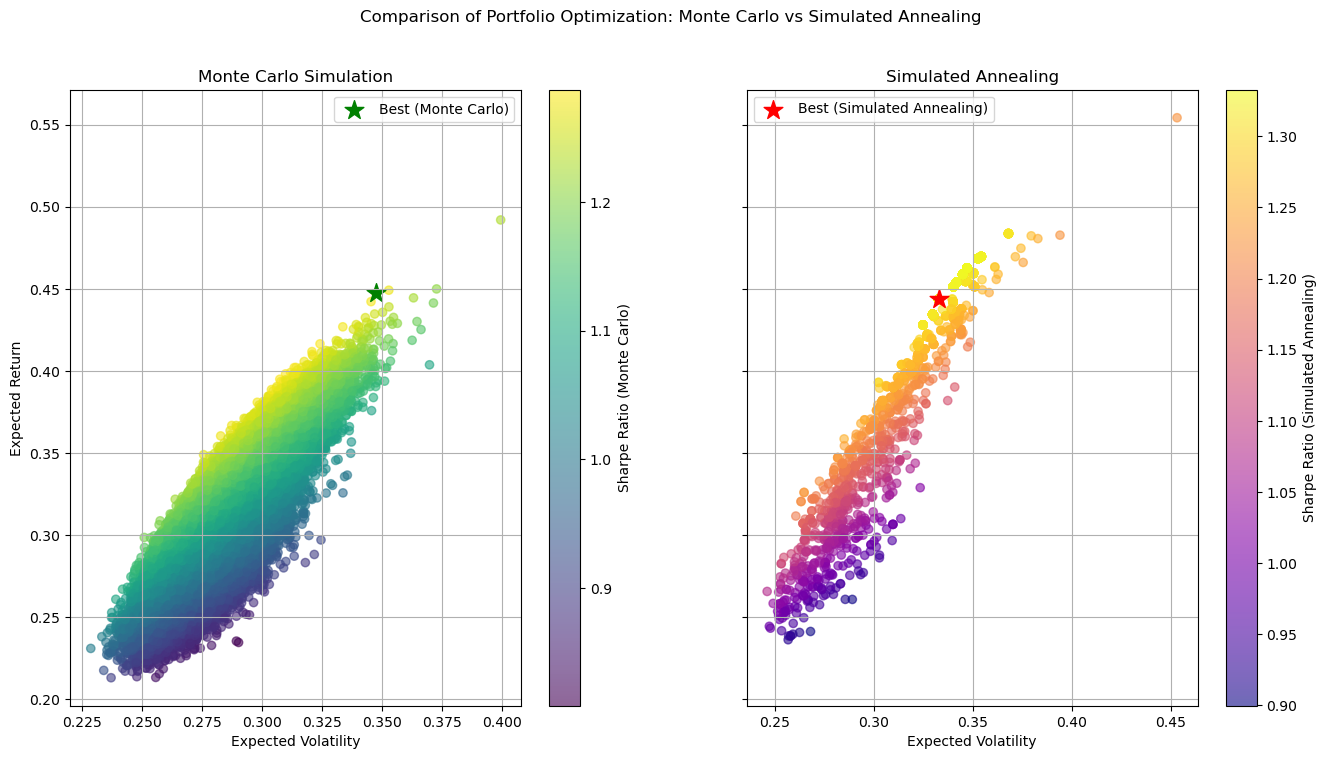

In [11]:

# Plot side-by-side comparison of Monte Carlo and Simulated Annealing results with best results highlighted
plot_both(results_df_mc, results_df_sa, 
                  {'Return': best_return_mc, 'Volatility': best_volatility_mc, 'Sharpe Ratio': best_sharpe_ratio_mc},
                  {'Return': best_return_sa, 'Volatility': best_volatility_sa, 'Sharpe Ratio': best_sharpe_ratio_sa})